Analyze the output of metagenome-atlas
======================================

In [1]:
# load libraries

%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

#load my scripts
from utils.mag_scripts import * 
from utils.barplots import * 

import os
os.environ['QT_QPA_PLATFORM']='offscreen' # ete3 has some interactive part, but we don't have acces to them here
import ete3

# supress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#go to output file 
%cd ../Example/

/home/animeshs/promec/GD/Tutorial/Example


# Taxonomy

In [3]:
Tax= pd.read_table('Results/taxonomy.tsv',index_col=0)
Tax.head()

,kindom,phylum,class,order,family,genus,species
user_genome,,,,,,,
MAG11,Bacteria,Firmicutes,Bacilli,Lactobacillales,Lactobacillaceae,Limosilactobacillus,Limosilactobacillus reuteri
MAG30,Bacteria,Firmicutes,Bacilli,Lactobacillales,Lactobacillaceae,Ligilactobacillus,Ligilactobacillus murinus
MAG08,Bacteria,Firmicutes,Bacilli,Lactobacillales,Lactobacillaceae,Lactobacillus,Lactobacillus johnsonii
MAG40,Bacteria,Firmicutes,Bacilli,Erysipelotrichales,Erysipelotrichaceae,Faecalibaculum,Faecalibaculum rodentium
MAG42,Bacteria,Firmicutes,Bacilli,Erysipelotrichales,Erysipelatoclostridiaceae,Erysipelatoclostridium,Erysipelatoclostridium cocleatum


In [4]:
# create a short label for each species
Labels=Tax.ffill(axis=1).species.copy()
Labels.loc[Tax.species.isnull()]+= ' '+ Labels.index[Tax.species.isnull()]

## Draw tree

In [5]:
T= ete3.Tree('genomes/tree/gtdbtk.bac120.nwk')

In [6]:
unique_phyla= Tax.phylum.unique()
phyla_colors= dict(zip(unique_phyla, 
['#bf423f',
 '#bf973f',
 '#91bf3f',
 '#3fbf42',
 '#3fbf97',
 '#3f91bf',
 '#423fbf',
 '#973fbf',
 '#bf3f91']))
    

def layout(node):
    node.img_style["size"] = 0
    if node.is_leaf():
        L= ete3.TextFace(Labels.loc[node.name])
        ete3.add_face_to_node(L, node, 0, position="branch-right")        
        node.set_style(ete3.NodeStyle(bgcolor= phyla_colors[Tax.loc[node.name,'phylum']]))
        


ts=ete3.TreeStyle()
ts.mode='c'
ts.show_leaf_name=False
ts.scale = 200

for ph in unique_phyla:
    ts.title.add_face(ete3.CircleFace(radius=15,color= phyla_colors[ph] ), column=0)
    ts.title.add_face(ete3.TextFace(ph, fsize=15), column=1)

T.render('%%inline',tree_style=ts,layout=layout)

AttributeError: module 'ete3' has no attribute 'TreeStyle'

# Genome quality 

In [7]:
genome_quality= pd.read_table('Results/genome_completeness.tsv',index_col=0)

genome_quality['Quality_Score']= genome_quality.eval('Completeness -5*Contamination')
genome_quality['Lineage']= genome_quality['Marker lineage'].map(lambda s: s.split()[0])

genome_quality['Id']= genome_quality.index

genome_quality= genome_quality.join(Tax)
genome_quality['Name']= Labels

In [9]:

xscale = alt.Scale(domain=(0, 10))
yscale = alt.Scale(domain=(50, 100))

alt.Chart(genome_quality).mark_circle(opacity= .6).encode(
    alt.X('Contamination', scale=xscale, title='Contamination [%]'),
    alt.Y('Completeness', scale=yscale, title='Completeness [%]'),
    color='phylum',
    tooltip=['Name', 'Id', 'Contamination','Completeness' ]
).interactive()

alt.Chart(...)

# Abundance

## Mapping rate

In [10]:
Counts= pd.read_csv('Results/counts/raw_counts_genomes.tsv',index_col=0,sep='\t').T
Counts.head()

Sample,MAG01,MAG02,MAG03,MAG04,MAG05,MAG06,MAG07,MAG08,MAG09,MAG10,...,MAG54,MAG55,MAG56,MAG57,MAG58,MAG59,MAG60,MAG61,MAG62,MAG63
ERR675518,17393,117204,240075,24199,97526,7149,6495,14480,4277446,1527105,...,837654,754481,222679,637364,2251197,13554,31078,598647,266917,50307
ERR675519,281563,34570,29109,726600,201572,842380,82081,899429,3267,158149,...,1032238,42293,63801,10632,2311946,219586,5,8844,380229,119444
ERR675520,26242,86293,109919,18037,104119,9283,14199,25,2791862,1290291,...,426057,758568,231036,281075,55038,13006,62974,8184,292100,105351
ERR675521,331737,36247,40084,747249,254551,936095,166398,572995,45186,186964,...,538591,83709,163914,13811,25583,194744,22,72826,283419,173115
ERR675522,23531,91372,35514,73140,36218,10569,5704,16,5908203,1051319,...,417819,530912,316013,15330,95070,28450,199,609486,158053,213068


Text(0.5, 1.0, 'Mapping rate')

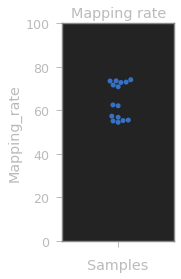

In [12]:
mapping_rate = pd.read_table('Results/mapping_rate.tsv',index_col=0,squeeze=True)*100
f,ax= plt.subplots(figsize=(2,4))
ax.set_ylim([0,100])
ax.set_xlabel('Samples')
sns.swarmplot(y= mapping_rate,ax=ax)

ax.set_title('Mapping rate')


## Relative abundance


For the relative abundance, we take the coverage over the genome, not the raw counts. This implicitly normalizes for genome size. The coverage is calculated as the median of the coverage values calculated in 1kb blocks.

In [13]:
D = pd.read_table("Results/counts/median_coverage_genomes.tsv",index_col=0)
D.head()

,MAG01,MAG02,MAG03,MAG04,MAG05,MAG06,MAG07,MAG08,MAG09,MAG10,...,MAG54,MAG55,MAG56,MAG57,MAG58,MAG59,MAG60,MAG61,MAG62,MAG63
ERR675518,0.00,6.020,6.47,0.24,1.82,0.02,0.16,0.50,104.515,41.08,...,33.375,15.760,2.67,17.44,42.300,0.31,1.41,21.75,7.375,0.57
ERR675519,5.59,1.320,0.00,10.47,3.36,19.18,2.53,41.03,0.000,3.83,...,42.480,0.620,0.96,0.21,44.725,10.14,0.00,0.31,10.930,0.24
ERR675520,0.22,4.950,2.58,0.12,1.34,0.09,0.41,0.00,72.945,34.41,...,17.345,16.875,3.22,7.94,0.170,0.34,3.02,0.24,8.275,2.65
ERR675521,5.82,1.720,0.00,12.07,3.21,21.45,5.16,25.56,1.090,4.34,...,21.865,1.510,2.63,0.27,0.000,8.49,0.00,2.72,8.115,0.42
ERR675522,0.00,4.085,0.36,1.03,0.76,0.17,0.15,0.00,153.425,32.31,...,16.600,11.800,4.89,0.00,0.000,0.92,0.00,22.82,4.380,5.41


In [14]:
#calculate relative abundance

relab = (D.T/D.sum(1)).T

Text(0, 0.5, 'Abundance [%]')

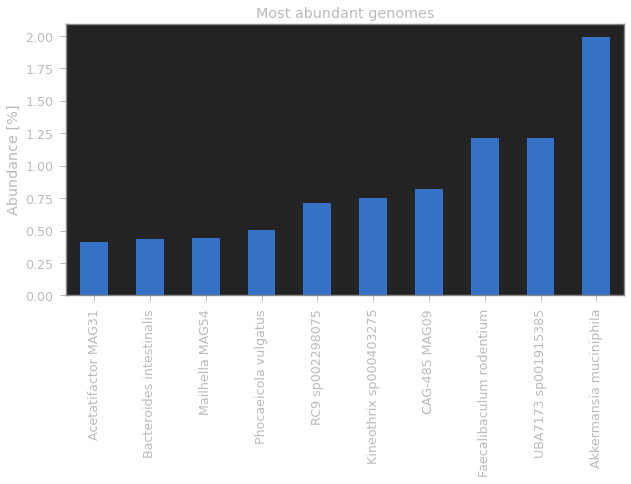

In [15]:
# get most abundant genomes

counts_per_genome= relab.sum().sort_values()
ax= counts_per_genome[-10:].plot.bar(figsize=(10,5))

_= ax.set_xticklabels(Labels.loc[counts_per_genome.index[-10:]])
ax.set_title('Most abundant genomes')
ax.set_ylabel('Abundance [%]')

### Typical bar chart

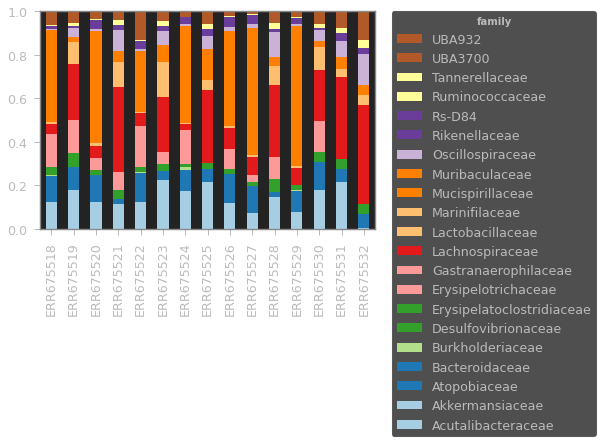

In [17]:

level='family'

grouped_data =relab.groupby(Tax[level],axis=1).sum()

ax= BarPlot(grouped_data)

ax.legend_.set_title(level,{'weight':'bold'})


# Functional annotation


Relative abundance of functional annotations per sample

The abundance is calculated as the sum of the relative abundance of all bacteria containing a function.

## CAZy

,AA10,CBM15,CBM20,CBM42,CBM48,CBM50,CBM6,CBM73,CE1,CE10,...,GT66,GT8,GT81,GT84,GT9,PL11,PL12,PL13,PL21,PL8
ERR675518,0.001264,0.001138,0.303127,0.154332,0.942357,0.136031,0.057485,0.001264,0.219176,0.078272,...,0.006327,0.094956,0.006817,0.020356,0.643034,0.090768,0.055620,0.033315,0.036128,0.234253
ERR675519,0.009996,0.007190,0.007372,0.000000,0.854865,0.218049,0.084719,0.009996,0.241016,0.187480,...,0.003498,0.121221,0.000000,0.000000,0.340819,0.032792,0.000753,0.000498,0.001664,0.110108
ERR675520,0.001276,0.012479,0.362556,0.244196,0.940441,0.125164,0.131176,0.001276,0.196501,0.055319,...,0.004490,0.103710,0.002940,0.018793,0.676785,0.146612,0.101647,0.089179,0.092849,0.209060
ERR675521,0.010213,0.006210,0.007736,0.000000,0.867113,0.179277,0.125514,0.010213,0.301467,0.281992,...,0.006194,0.129034,0.000000,0.000000,0.271159,0.105578,0.001632,0.001224,0.005197,0.074243
ERR675522,0.001489,0.023959,0.196098,0.000102,0.958049,0.129958,0.106068,0.001489,0.272423,0.163352,...,0.007062,0.078737,0.000458,0.022929,0.497926,0.116489,0.055846,0.055846,0.062068,0.288945


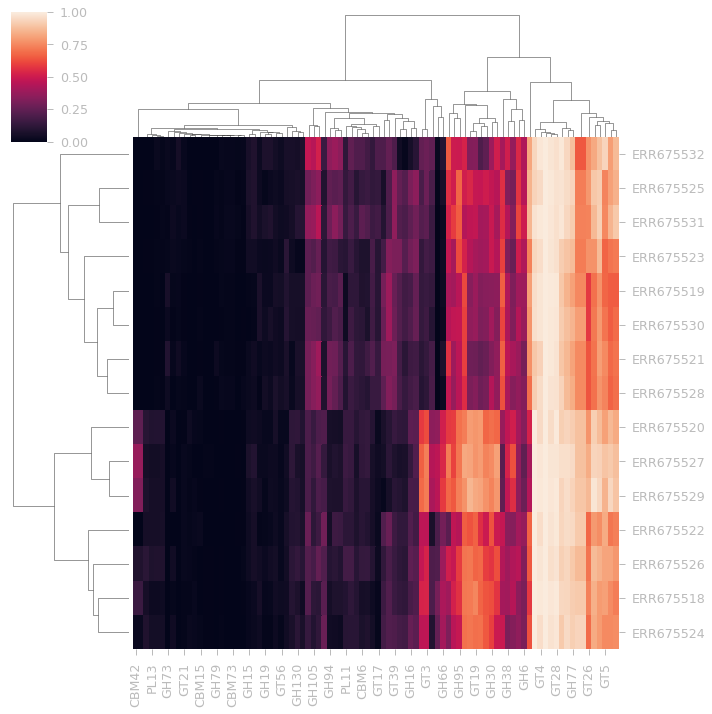

In [19]:
#CAZy
CAZy_annotations_genome= pd.read_table('Results/annotations/CAZy.tsv',index_col=0)
CAZy_presence= (CAZy_annotations_genome>0).astype(int)
CAZy_presence.head()


function_relab = relab @ CAZy_presence

sns.clustermap(function_relab)

function_relab.head()

## Kegg orthologs

,K00001,K00002,K00003,K00004,K00005,K00008,K00009,K00010,K00012,K00013,...,K22457,K22465,K22466,K22468,K22476,K22477,K22491,K22503,K22507,K22510
ERR675518,0.440011,0.010183,0.915543,0.013460,0.025587,0.701019,0.246648,0.003804,0.760464,0.639489,...,0.545924,0.035164,0.035164,0.005953,0.000695,0.033952,0.576873,0.004562,0.035164,0.087191
ERR675519,0.713561,0.130889,0.929096,0.087197,0.096506,0.716695,0.239012,0.034383,0.637860,0.778399,...,0.135207,0.051593,0.051593,0.000000,0.012084,0.261249,0.258905,0.098892,0.051593,0.349381
ERR675520,0.367651,0.015294,0.890621,0.012924,0.001744,0.707926,0.252043,0.012947,0.849752,0.639820,...,0.670135,0.019768,0.019768,0.000000,0.000866,0.049444,0.686244,0.014109,0.019768,0.082045
ERR675521,0.597525,0.178544,0.923294,0.193653,0.072083,0.741207,0.381346,0.050855,0.631179,0.705883,...,0.117725,0.033035,0.033035,0.000000,0.018810,0.376398,0.248179,0.162378,0.033035,0.525261
ERR675522,0.479559,0.010650,0.905161,0.014900,0.043784,0.640964,0.328581,0.014607,0.682489,0.553677,...,0.403691,0.021122,0.021122,0.003728,0.000611,0.056711,0.497869,0.027955,0.021122,0.091461


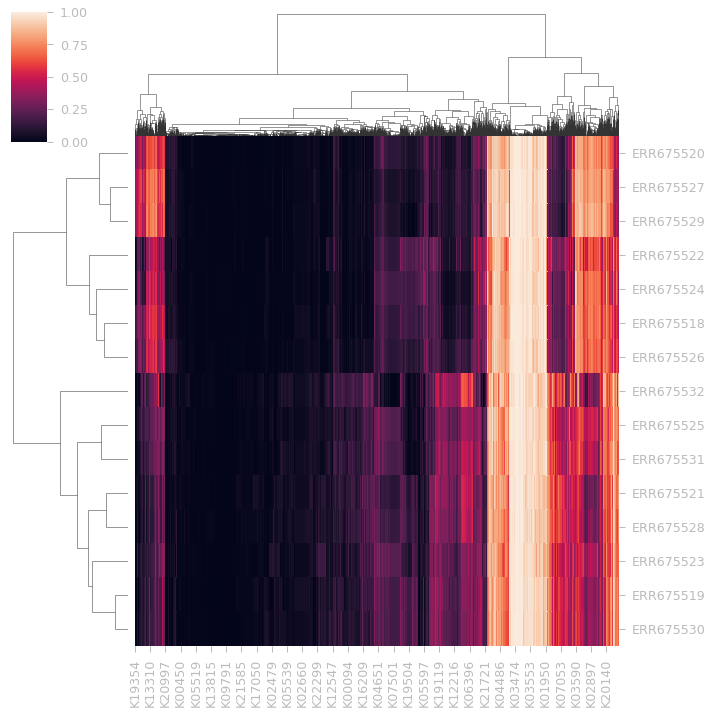

In [20]:
#Kegg orthologs

Kegg_annotations_genome= pd.read_table('Results/annotations/KO.tsv',index_col=0)
Kegg_presence= (Kegg_annotations_genome>0).astype(int)
Kegg_presence.head()


function_relab = relab @ Kegg_presence

sns.clustermap(function_relab)

function_relab.head()